# **Naive Bayes Classification with TensorFlow Probability**

## 📑 Table of Contents

- **1. [Import Libraries and Dependencies](#1-import-libraries-and-dependencies)**
- **2. [Data Loading and Preprocessing](#2-data-loading-and-preprocessing)**
- **3. [Exploratory Data Analysis and Visualization](#3-exploratory-data-analysis-and-visualization)**
- **4. [Laplace Smoothing Implementation](#4-laplace-smoothing-implementation)**
- **5. [Class Prior Computation](#5-class-prior-computation)**
- **6. [TensorFlow Probability Distribution Setup](#6-tensorflow-probability-distribution-setup)**
- **7. [Prediction and Classification Functions](#7-prediction-and-classification-functions)**
- **8. [Performance Evaluation and Comparison](#8-performance-evaluation-and-comparison)**
- **9. [Results Visualization and Analysis](#9-results-visualization-and-analysis)**
- **10. [Detailed Classification Report](#10-detailed-classification-report)**
- **11. [Sample Predictions Analysis](#11-sample-predictions-analysis)**

## **1. Import Libraries and Dependencies**

In [19]:
# Core libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

# TensorFlow Probability distributions
tfd = tfp.distributions

# Scikit-learn for dataset and comparison
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.20.0
TensorFlow Probability version: 0.25.0


## **2. Data Loading and Preprocessing**

In [20]:
# Define data path
path = "_data/newsgroup_data/20news-bydate_py3.pkz"

In [21]:
def get_data(categories, data_home=path):
    """
    Fetches and preprocesses the 20 newsgroups dataset.
    
    Args:
        categories (list): List of newsgroup categories to fetch
        data_home (str): Directory to store the dataset
    
    Returns:
        tuple: Training and testing data with labels
            - (train_features, train_labels): Training binary bag-of-words matrix and labels
            - (test_features, test_labels): Testing binary bag-of-words matrix and labels
    """
    
    # Fetch training and testing datasets
    newsgroups_train_data = fetch_20newsgroups(
        data_home=data_home,
        subset='train', 
        categories=categories,
        remove=('headers', 'footers', 'quotes')  # Remove metadata for cleaner text
    )
    
    newsgroups_test_data = fetch_20newsgroups(
        data_home=data_home,
        subset='test', 
        categories=categories,
        remove=('headers', 'footers', 'quotes')
    )
    
    # Calculate document count for min_df parameter
    n_documents = len(newsgroups_test_data['data'])
    
    # Initialize CountVectorizer with binary output and frequency filtering
    count_vectorizer = CountVectorizer(
        input='content',           # Input is raw text
        binary=True,              # Binary bag-of-words (presence/absence)
        max_df=0.25,             # Ignore terms that appear in >25% of documents
        min_df=1.01/n_documents, # Ignore terms that appear in <2 documents
        stop_words='english'      # Remove common English stop words
    )
    
    # Fit vectorizer on training data and transform both sets
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data'])
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data'])
    
    print(f"Training documents: {len(newsgroups_train_data['data'])}")
    print(f"Testing documents: {len(newsgroups_test_data['data'])}")
    print(f"Vocabulary size: {len(count_vectorizer.vocabulary_)}")
    
    return (
        (train_binary_bag_of_words.todense(), newsgroups_train_data['target']),
        (test_binary_bag_of_words.todense(), newsgroups_test_data['target']),
        count_vectorizer
    )

# Define categories for classification
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# Load and preprocess data
(train_data, train_labels), (test_data, test_labels), vectorizer = get_data(categories=categories)

print(f"\nSelected categories: {categories}")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training documents: 2034
Testing documents: 1353
Vocabulary size: 12148

Selected categories: ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
Training data shape: (2034, 12148)
Test data shape: (1353, 12148)


## **3. Exploratory Data Analysis and Visualization**

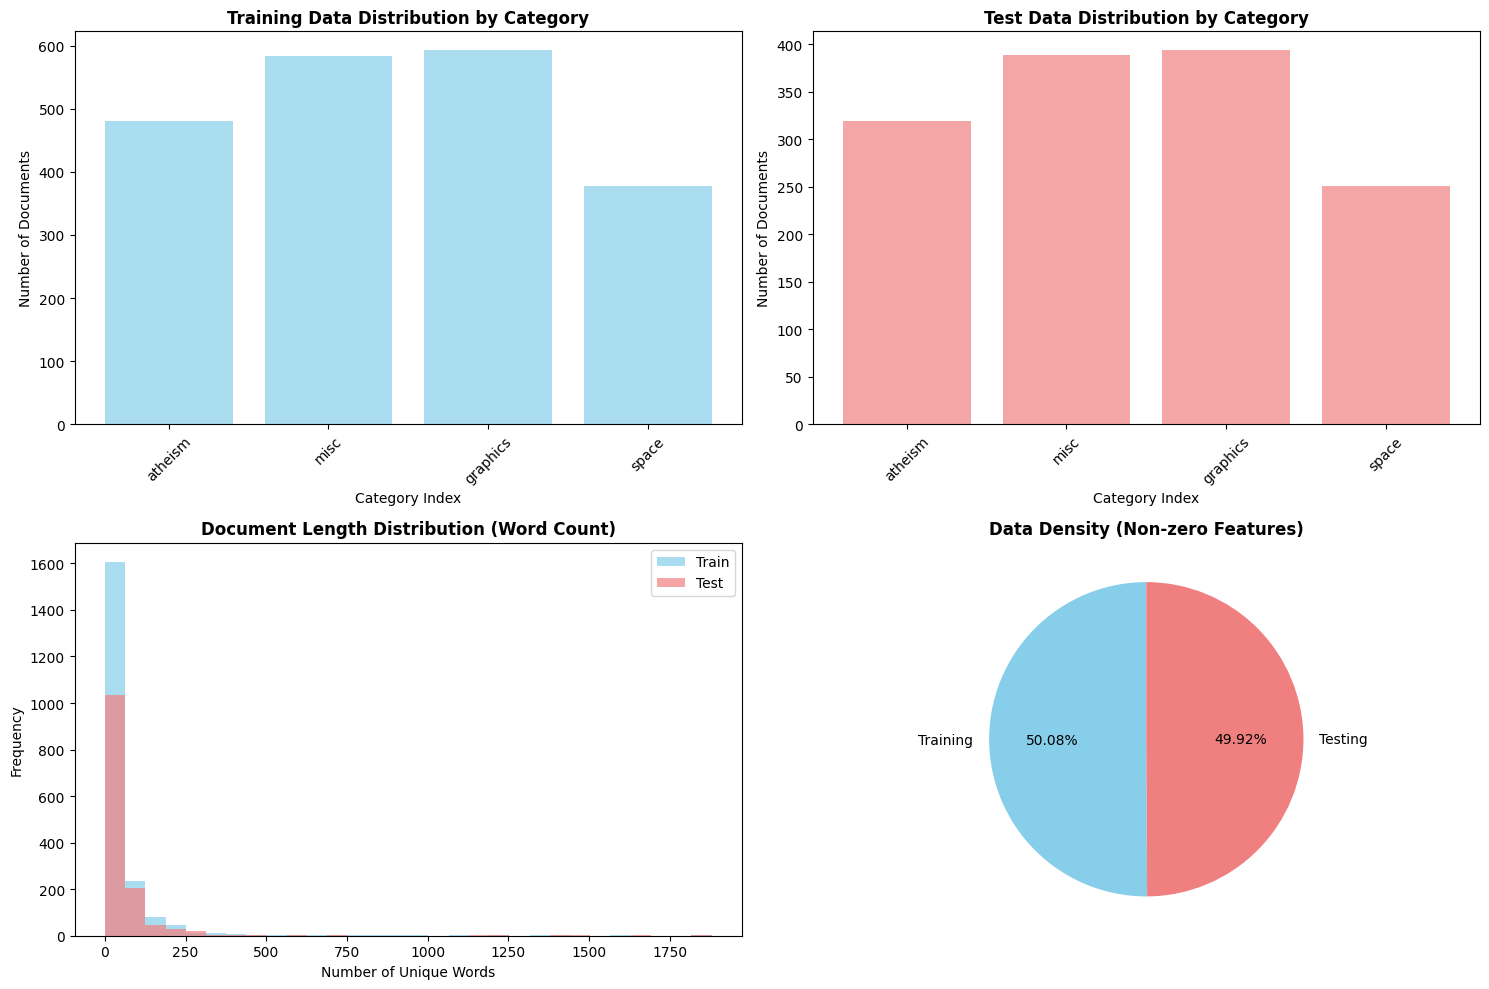

Average document length (train): 58.61 ± 121.34
Average document length (test): 58.41 ± 131.21
Data sparsity (train): 0.9952
Data sparsity (test): 0.9952


In [22]:
# Create visualizations for dataset exploration
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class distribution in training data
train_counts = np.bincount(train_labels)
axes[0, 0].bar(range(len(categories)), train_counts, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Training Data Distribution by Category', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Category Index')
axes[0, 0].set_ylabel('Number of Documents')
axes[0, 0].set_xticks(range(len(categories)))
axes[0, 0].set_xticklabels([cat.split('.')[-1] for cat in categories], rotation=45)

# 2. Class distribution in test data
test_counts = np.bincount(test_labels)
axes[0, 1].bar(range(len(categories)), test_counts, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Test Data Distribution by Category', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Category Index')
axes[0, 1].set_ylabel('Number of Documents')
axes[0, 1].set_xticks(range(len(categories)))
axes[0, 1].set_xticklabels([cat.split('.')[-1] for cat in categories], rotation=45)

# 3. Document length distribution
doc_lengths_train = np.sum(train_data, axis=1).A1
doc_lengths_test = np.sum(test_data, axis=1).A1

axes[1, 0].hist(doc_lengths_train, bins=30, alpha=0.7, label='Train', color='skyblue')
axes[1, 0].hist(doc_lengths_test, bins=30, alpha=0.7, label='Test', color='lightcoral')
axes[1, 0].set_title('Document Length Distribution (Word Count)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Unique Words')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Feature sparsity visualization
sparsity_train = (train_data == 0).sum() / train_data.size
sparsity_test = (test_data == 0).sum() / test_data.size

sparsity_data = [1-sparsity_train, 1-sparsity_test]
labels = ['Training', 'Testing']
colors = ['skyblue', 'lightcoral']

axes[1, 1].pie(sparsity_data, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
axes[1, 1].set_title('Data Density (Non-zero Features)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Average document length (train): {doc_lengths_train.mean():.2f} ± {doc_lengths_train.std():.2f}")
print(f"Average document length (test): {doc_lengths_test.mean():.2f} ± {doc_lengths_test.std():.2f}")
print(f"Data sparsity (train): {sparsity_train:.4f}")
print(f"Data sparsity (test): {sparsity_test:.4f}")

## **4. Laplace Smoothing Implementation**

In [23]:
def laplace_smoothing(labels, binary_data, n_classes, alpha=1.0):
    """
    Applies Laplace (add-alpha) smoothing to compute class-conditional probabilities.
    
    This function addresses the zero-probability problem in Naive Bayes by adding
    a small constant (alpha) to all feature counts.
    
    Args:
        labels (array): Class labels for training data
        binary_data (array): Binary feature matrix (documents x features)
        n_classes (int): Number of classes
        alpha (float): Smoothing parameter (default: 1.0 for Laplace smoothing)
    
    Returns:
        numpy.ndarray: Smoothed probability matrix (n_classes x n_features)
                    theta[i,j] = P(feature_j | class_i)
    """
    
    n_words = binary_data.shape[1]
    theta = np.zeros([n_classes, n_words])  # Parameter matrix: P(word | class)
    
    print(f"Applying Laplace smoothing with alpha = {alpha}")
    print(f"Feature matrix shape: {binary_data.shape}")
    
    for c_k in range(n_classes):
        # Create boolean mask for current class
        class_mask = (labels == c_k)
        N = class_mask.sum()  # Number of documents in current class
        
        # Compute smoothed probabilities: (count + alpha) / (N + 2*alpha)
        # The denominator accounts for both presence (1) and absence (0) of features
        feature_counts = binary_data[class_mask, :].sum(axis=0)
        theta[c_k, :] = (feature_counts + alpha) / (N + alpha * 2)
        
        print(f"Class {c_k} ({categories[c_k]}): {N} documents")
    
    return theta

# Apply Laplace smoothing to training data
smoothed_probabilities = laplace_smoothing(
    labels=train_labels, 
    binary_data=train_data, 
    n_classes=len(categories),
    alpha=1.0
)

print(f"\nSmoothed probability matrix shape: {smoothed_probabilities.shape}")
print(f"Sample probabilities for first 5 features in each class:")
print(smoothed_probabilities[:, :5])

Applying Laplace smoothing with alpha = 1.0
Feature matrix shape: (2034, 12148)
Class 0 (alt.atheism): 480 documents
Class 1 (talk.religion.misc): 584 documents
Class 2 (comp.graphics): 593 documents
Class 3 (sci.space): 377 documents

Smoothed probability matrix shape: (4, 12148)
Sample probabilities for first 5 features in each class:
[[0.00207469 0.01452282 0.00207469 0.00207469 0.00207469]
 [0.02730375 0.01535836 0.00170648 0.00170648 0.00170648]
 [0.02521008 0.04705882 0.00504202 0.00504202 0.00504202]
 [0.00527704 0.01846966 0.00263852 0.00263852 0.00263852]]


## **5. Class Prior Computation**

Class Prior Probabilities:
  Class 0 (alt.atheism): 0.2360
  Class 1 (talk.religion.misc): 0.2871
  Class 2 (comp.graphics): 0.2915
  Class 3 (sci.space): 0.1853


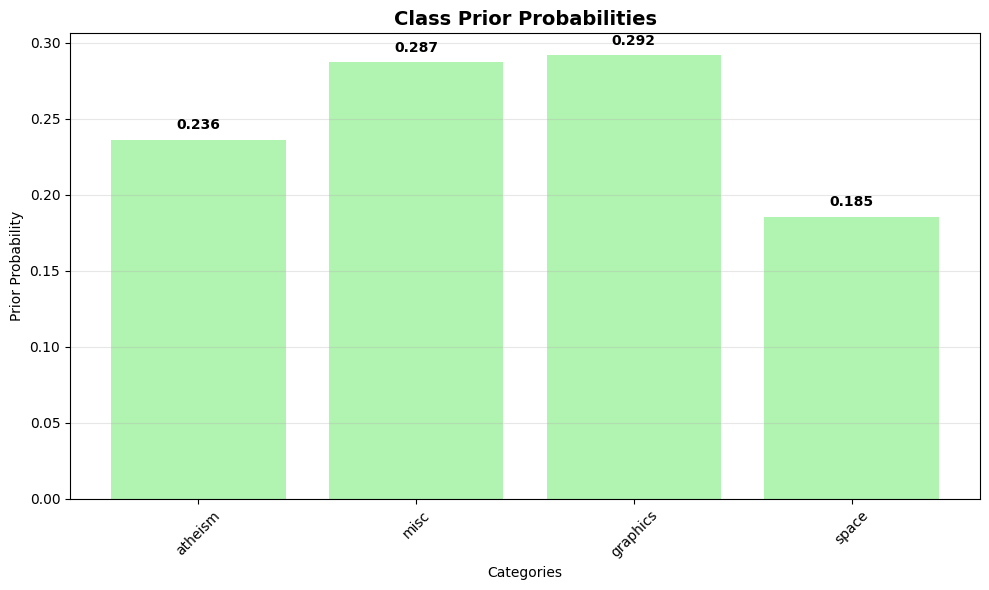

In [24]:
def compute_class_priors(n_classes, labels):
    """
    Computes prior probabilities for each class based on training data frequency.
    
    Args:
        n_classes (int): Number of classes
        labels (array): Training labels
    
    Returns:
        numpy.ndarray: Prior probabilities for each class
    """
    
    counts = np.zeros(n_classes)
    
    # Count occurrences of each class
    for c_k in range(n_classes):
        counts[c_k] = np.sum(labels == c_k)
    
    # Normalize to get probabilities
    priors = counts / np.sum(counts)
    
    print('Class Prior Probabilities:')
    for i, (category, prior) in enumerate(zip(categories, priors)):
        print(f'  Class {i} ({category}): {prior:.4f}')
    
    return priors

# Compute class priors
class_priors = compute_class_priors(n_classes=len(categories), labels=train_labels)

# Visualize class priors
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(categories)), class_priors, color='lightgreen', alpha=0.7)
plt.title('Class Prior Probabilities', fontsize=14, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Prior Probability')
plt.xticks(range(len(categories)), [cat.split('.')[-1] for cat in categories], rotation=45)

# Add value labels on bars
for i, (bar, prior) in enumerate(zip(bars, class_priors)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{prior:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## **6. TensorFlow Probability Distribution Setup**

In [25]:
def create_bernoulli_distributions(probabilities):
    """
    Creates a batch of independent Bernoulli distributions for Naive Bayes classification.
    
    Each class gets its own set of Bernoulli distributions (one per feature),
    and features are assumed to be conditionally independent given the class.
    
    Args:
        probabilities (array): Smoothed probability matrix (n_classes x n_features)
    
    Returns:
        tfp.distributions.Independent: Batch of independent Bernoulli distributions
    """
    
    # Create a batch of Bernoulli distributions
    # Shape: (n_classes, n_features)
    batch_of_bernoullis = tfd.Bernoulli(probs=probabilities)
    
    # Make features independent within each class
    # This reduces the batch dimension by treating the last dimension as event shape
    independent_features = tfd.Independent(
        batch_of_bernoullis,
        reinterpreted_batch_ndims=1  # Treat the feature dimension as event shape
    )
    
    return independent_features

# Create TensorFlow Probability distributions
tf_distributions = create_bernoulli_distributions(smoothed_probabilities)

print("TensorFlow Probability Distribution:")
print(f"Batch shape (number of classes): {tf_distributions.batch_shape}")
print(f"Event shape (number of features): {tf_distributions.event_shape}")
print(f"Distribution type: {type(tf_distributions)}")

# Sample from the distribution to verify it works
sample = tf_distributions.sample(1)
print(f"\nSample shape from distribution: {sample.shape}")

TensorFlow Probability Distribution:
Batch shape (number of classes): (4,)
Event shape (number of features): (12148,)
Distribution type: <class 'tensorflow_probability.python.distributions.independent.Independent'>

Sample shape from distribution: (1, 4, 12148)


## **7. Prediction and Classification Functions**

In [26]:
def predict_single_sample(distribution, sample, priors):
    """
    Predicts class probabilities for a single sample using Naive Bayes.
    
    Computes: P(class | sample) ∝ P(sample | class) × P(class)
    
    Args:
        distribution: TensorFlow Probability distribution object
        sample (array): Binary feature vector for a single document
        priors (array): Class prior probabilities
    
    Returns:
        tf.Tensor: Log probabilities for each class (normalized)
    """
    
    # Compute log P(sample | class) for each class
    class_conditional_log_probs = distribution.log_prob(sample)
    
    # Convert priors to TensorFlow tensor with matching dtype
    priors_tensor = tf.convert_to_tensor(priors, dtype=class_conditional_log_probs.dtype)
    
    # Compute log P(sample, class) = log P(sample | class) + log P(class)
    joint_log_likelihood = tf.add(tf.math.log(priors_tensor), class_conditional_log_probs)
    
    # Normalize using log-sum-exp trick for numerical stability
    # P(class | sample) = P(sample, class) / P(sample)
    normalization_factor = tf.math.reduce_logsumexp(
        joint_log_likelihood, axis=-1, keepdims=True
    )
    log_posterior = joint_log_likelihood - normalization_factor
    
    return log_posterior


def classify_all_samples(distribution, test_data, test_labels, priors):
    """
    Classifies all test samples and computes performance metrics.
    
    Args:
        distribution: TensorFlow Probability distribution object
        test_data (array): Test feature matrix
        test_labels (array): True test labels
        priors (array): Class prior probabilities
    
    Returns:
        tuple: (predicted_classes, probabilities, log_probabilities, f1_macro)
    """
    
    probabilities = []
    log_probabilities = []
    
    print("Classifying test samples...")
    
    # Process each test sample
    for i, (sample, true_label) in enumerate(zip(test_data, test_labels)):
        # Ensure sample is properly shaped and typed
        sample_tensor = tf.convert_to_tensor(sample.A1 if hasattr(sample, 'A1') else sample, 
                                           dtype=tf.float32)
        
        log_prob = predict_single_sample(distribution, sample_tensor, priors)
        prob = tf.exp(log_prob)
        
        probabilities.append(prob.numpy())
        log_probabilities.append(log_prob.numpy())
        
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(test_data)} samples")
    
    # Convert to numpy arrays
    probabilities = np.array(probabilities)
    log_probabilities = np.array(log_probabilities)
    
    # Get predicted classes
    predicted_classes = np.argmax(probabilities, axis=-1)
    
    # Compute performance metrics
    f1_macro = f1_score(test_labels, predicted_classes, average='macro')
    f1_micro = f1_score(test_labels, predicted_classes, average='micro')
    
    print(f"\nClassification Results:")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Micro F1-Score: {f1_micro:.4f}")
    
    return predicted_classes, probabilities, log_probabilities, f1_macro


# Perform classification
predicted_classes, probabilities, log_probabilities, tf_f1_score = classify_all_samples(
    tf_distributions, test_data, test_labels, class_priors)

Classifying test samples...
Processed 100/1353 samples
Processed 200/1353 samples
Processed 300/1353 samples
Processed 400/1353 samples
Processed 500/1353 samples
Processed 600/1353 samples
Processed 700/1353 samples
Processed 800/1353 samples
Processed 900/1353 samples
Processed 1000/1353 samples
Processed 1100/1353 samples
Processed 1200/1353 samples
Processed 1300/1353 samples

Classification Results:
Macro F1-Score: 0.5610
Micro F1-Score: 0.6075


## **8. Performance Evaluation and Comparison**

In [27]:
# Compare with sklearn's BernoulliNB
print("=" * 50)
print("COMPARISON WITH SCIKIT-LEARN")
print("=" * 50)

# Convert matrix data to arrays for sklearn compatibility
train_data_array = np.asarray(train_data)
test_data_array = np.asarray(test_data)

# Train sklearn Bernoulli Naive Bayes with same smoothing parameter
sklearn_clf = BernoulliNB(alpha=1.0)
sklearn_clf.fit(train_data_array, train_labels)
sklearn_predictions = sklearn_clf.predict(test_data_array)
sklearn_f1_macro = f1_score(test_labels, sklearn_predictions, average='macro')
sklearn_f1_micro = f1_score(test_labels, sklearn_predictions, average='micro')

print(f"TensorFlow Probability Implementation:")
print(f"  Macro F1-Score: {tf_f1_score:.4f}")

print(f"\nScikit-learn BernoulliNB:")
print(f"  Macro F1-Score: {sklearn_f1_macro:.4f}")
print(f"  Micro F1-Score: {sklearn_f1_micro:.4f}")

print(f"\nDifference in Macro F1-Score: {abs(tf_f1_score - sklearn_f1_macro):.6f}")

COMPARISON WITH SCIKIT-LEARN
TensorFlow Probability Implementation:
  Macro F1-Score: 0.5610

Scikit-learn BernoulliNB:
  Macro F1-Score: 0.5610
  Micro F1-Score: 0.6075

Difference in Macro F1-Score: 0.000000


## **9. Results Visualization and Analysis**

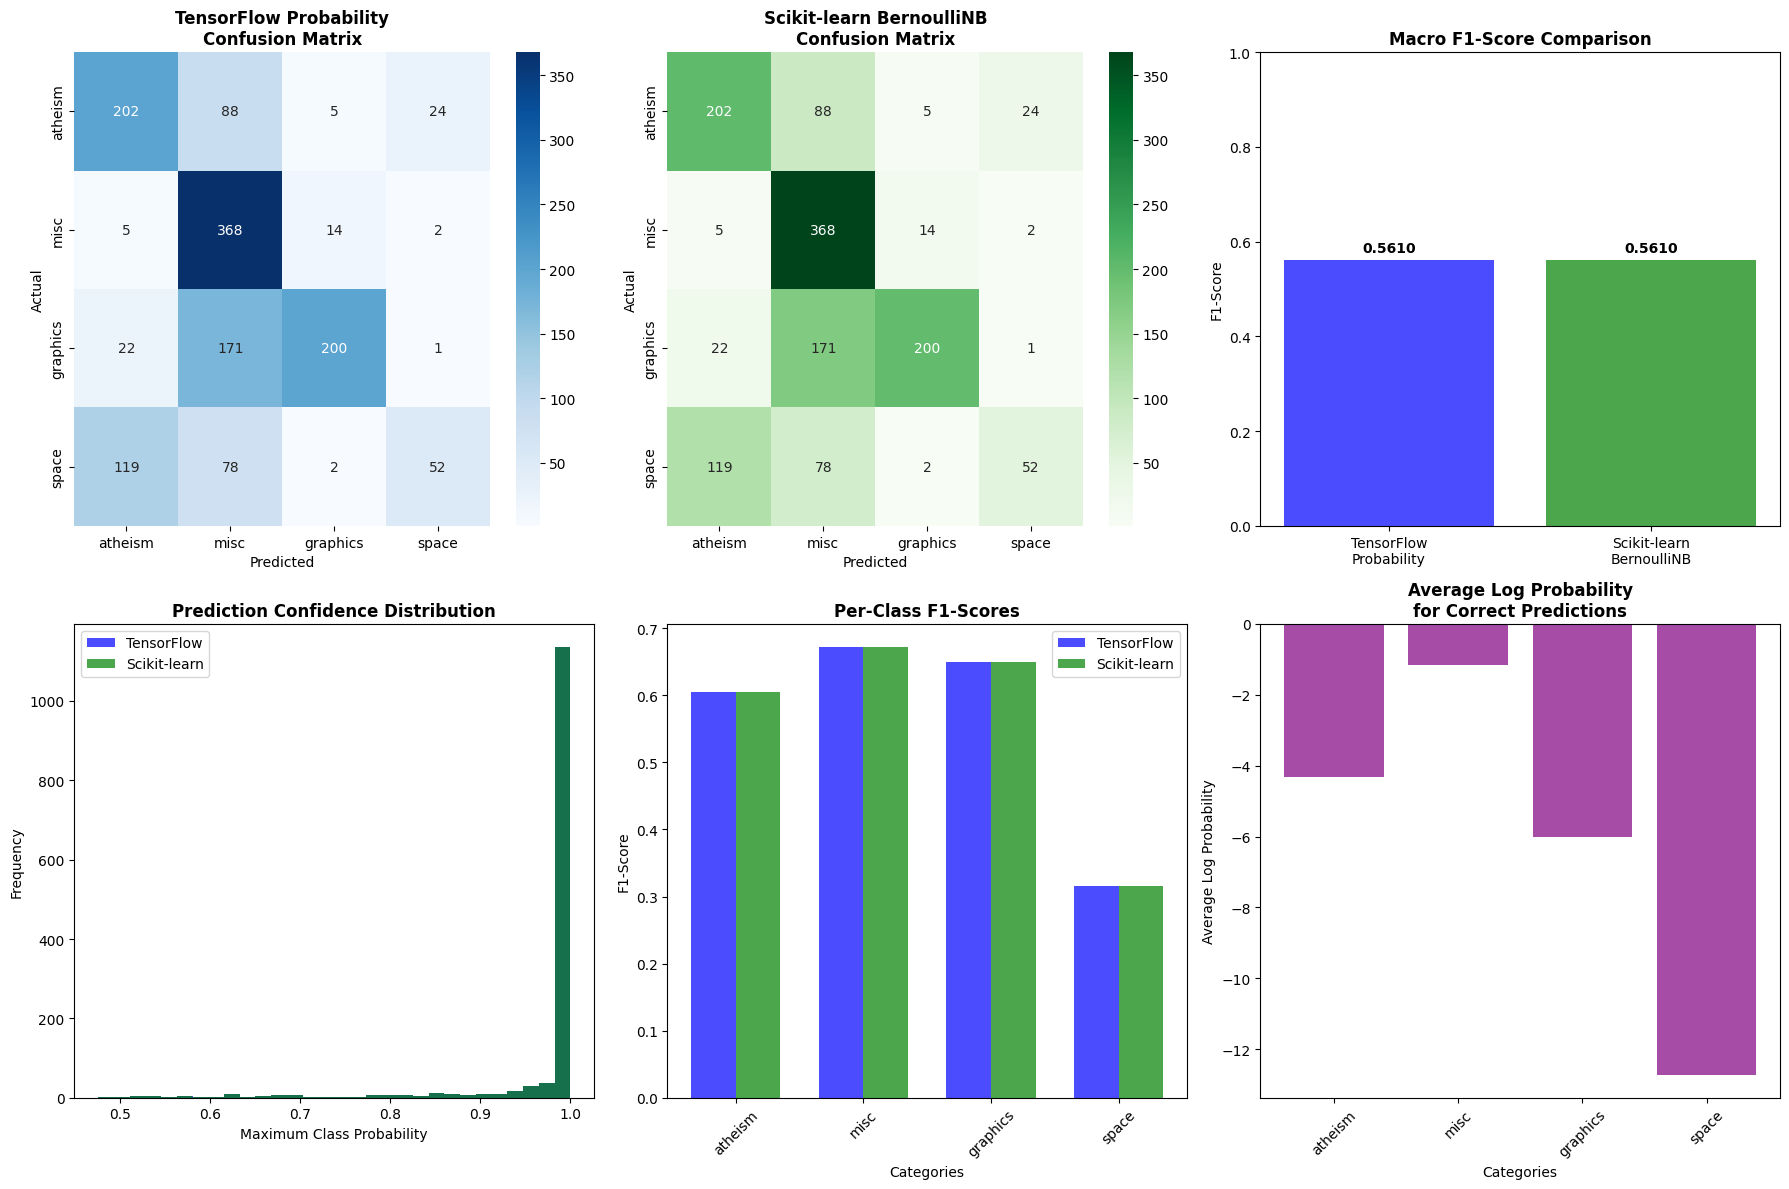

In [28]:
# Create comprehensive visualization of results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Use simple color names instead of hex codes
simple_colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

# 1. Confusion Matrix for TensorFlow Implementation
cm_tf = confusion_matrix(test_labels, predicted_classes)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[cat.split('.')[-1] for cat in categories],
            yticklabels=[cat.split('.')[-1] for cat in categories],
            ax=axes[0, 0])
axes[0, 0].set_title('TensorFlow Probability\nConfusion Matrix', fontweight='bold')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. Confusion Matrix for Scikit-learn
cm_sklearn = confusion_matrix(test_labels, sklearn_predictions)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Greens',
            xticklabels=[cat.split('.')[-1] for cat in categories],
            yticklabels=[cat.split('.')[-1] for cat in categories],
            ax=axes[0, 1])
axes[0, 1].set_title('Scikit-learn BernoulliNB\nConfusion Matrix', fontweight='bold')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. F1-Score Comparison
methods = ['TensorFlow\nProbability', 'Scikit-learn\nBernoulliNB']
f1_scores = [tf_f1_score, sklearn_f1_macro]

bars = axes[0, 2].bar(methods, f1_scores, color=['blue', 'green'], alpha=0.7)
axes[0, 2].set_title('Macro F1-Score Comparison', fontweight='bold')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Prediction Confidence Distribution
max_probs_tf = np.max(probabilities, axis=1)
# Use the array version for sklearn operations
max_probs_sklearn = np.max(sklearn_clf.predict_proba(test_data_array), axis=1)

axes[1, 0].hist(max_probs_tf, bins=30, alpha=0.7, label='TensorFlow', color='blue')
axes[1, 0].hist(max_probs_sklearn, bins=30, alpha=0.7, label='Scikit-learn', color='green')
axes[1, 0].set_title('Prediction Confidence Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Maximum Class Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 5. Per-class F1 Scores
f1_per_class_tf = f1_score(test_labels, predicted_classes, average=None)
f1_per_class_sklearn = f1_score(test_labels, sklearn_predictions, average=None)

x_pos = np.arange(len(categories))
width = 0.35

axes[1, 1].bar(x_pos - width/2, f1_per_class_tf, width, label='TensorFlow', color='blue', alpha=0.7)
axes[1, 1].bar(x_pos + width/2, f1_per_class_sklearn, width, label='Scikit-learn', color='green', alpha=0.7)

axes[1, 1].set_title('Per-Class F1-Scores', fontweight='bold')
axes[1, 1].set_xlabel('Categories')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([cat.split('.')[-1] for cat in categories], rotation=45)
axes[1, 1].legend()

# 6. Log Probability Distribution
avg_log_probs_per_class = []
for class_idx in range(len(categories)):
    class_mask = test_labels == class_idx
    if np.any(class_mask):  # Check if class exists in test data
        avg_log_prob = np.mean(log_probabilities[class_mask][:, class_idx])
        avg_log_probs_per_class.append(avg_log_prob)
    else:
        avg_log_probs_per_class.append(0)  # Handle empty classes

axes[1, 2].bar(range(len(categories)), avg_log_probs_per_class, color='purple', alpha=0.7)
axes[1, 2].set_title('Average Log Probability\nfor Correct Predictions', fontweight='bold')
axes[1, 2].set_xlabel('Categories')
axes[1, 2].set_ylabel('Average Log Probability')
axes[1, 2].set_xticks(range(len(categories)))
axes[1, 2].set_xticklabels([cat.split('.')[-1] for cat in categories], rotation=45)

plt.tight_layout()
plt.show()

## **10. Detailed Classification Report**

In [29]:
# Generate detailed classification report
print("=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)

print("\n📊 TensorFlow Probability Implementation:")
print("-" * 50)
tf_report = classification_report(test_labels, predicted_classes, 
                                  target_names=categories, digits=4)
print(tf_report)

print("\n📊 Scikit-learn BernoulliNB:")
print("-" * 50)
sklearn_report = classification_report(test_labels, sklearn_predictions, 
                                       target_names=categories, digits=4)
print(sklearn_report)

# Summary statistics
print("\n📈 SUMMARY STATISTICS:")
print("-" * 50)
print(f"Dataset: 20 Newsgroups (subset of {len(categories)} categories)")
print(f"Training samples: {len(train_labels)}")
print(f"Test samples: {len(test_labels)}")
print(f"Feature dimension: {train_data.shape[1]}")
print(f"Smoothing parameter (α): 1.0")
print(f"\nImplementation agreement: {np.mean(predicted_classes == sklearn_predictions):.4f}")

DETAILED CLASSIFICATION REPORT

📊 TensorFlow Probability Implementation:
--------------------------------------------------
                    precision    recall  f1-score   support

       alt.atheism     0.5805    0.6332    0.6057       319
talk.religion.misc     0.5220    0.9460    0.6728       389
     comp.graphics     0.9050    0.5076    0.6504       394
         sci.space     0.6582    0.2072    0.3152       251

          accuracy                         0.6075      1353
         macro avg     0.6664    0.5735    0.5610      1353
      weighted avg     0.6726    0.6075    0.5841      1353


📊 Scikit-learn BernoulliNB:
--------------------------------------------------
                    precision    recall  f1-score   support

       alt.atheism     0.5805    0.6332    0.6057       319
talk.religion.misc     0.5220    0.9460    0.6728       389
     comp.graphics     0.9050    0.5076    0.6504       394
         sci.space     0.6582    0.2072    0.3152       251

          a

## **11. Sample Predictions Analysis**

In [30]:
# Analyze some sample predictions
print("=" * 70)
print("SAMPLE PREDICTIONS ANALYSIS")
print("=" * 70)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Find some interesting examples
sample_indices = [0, 10, 25, 50, 100]

for idx in sample_indices:
    sample_features = test_data[idx]
    true_label = test_labels[idx]
    predicted_label = predicted_classes[idx]
    sample_probs = probabilities[idx]
    
    print(f"\n📄 Sample {idx}:")
    print(f"True category: {categories[true_label]}")
    print(f"Predicted category: {categories[predicted_label]}")
    print(f"Prediction correct: {'✅' if true_label == predicted_label else '❌'}")
    
    print("\nClass probabilities:")
    for i, (cat, prob) in enumerate(zip(categories, sample_probs)):
        marker = "👉" if i == predicted_label else "  "
        print(f"{marker} {cat}: {prob:.4f}")
    
    # Show top features for this document
    active_features = np.where(sample_features.A1 == 1)[0]
    if len(active_features) > 0:
        print(f"\nActive features (first 10): {[feature_names[i] for i in active_features[:10]]}")
    
    print("-" * 50)

SAMPLE PREDICTIONS ANALYSIS

📄 Sample 0:
True category: comp.graphics
Predicted category: talk.religion.misc
Prediction correct: ❌

Class probabilities:
   alt.atheism: 0.0000
👉 talk.religion.misc: 1.0000
   comp.graphics: 0.0000
   sci.space: 0.0000

Active features (first 10): ['arizona', 'project']
--------------------------------------------------

📄 Sample 10:
True category: talk.religion.misc
Predicted category: talk.religion.misc
Prediction correct: ✅

Class probabilities:
   alt.atheism: 0.0000
👉 talk.religion.misc: 1.0000
   comp.graphics: 0.0000
   sci.space: 0.0000

Active features (first 10): ['advance', 'away', 'card', 'come', 'couple', 'dan', 'diamond', 'does', 'driver', 'information']
--------------------------------------------------

📄 Sample 25:
True category: comp.graphics
Predicted category: alt.atheism
Prediction correct: ❌

Class probabilities:
👉 alt.atheism: 0.4754
   talk.religion.misc: 0.1420
   comp.graphics: 0.3826
   sci.space: 0.0000

Active features (first